In [35]:
!pip install pyspark

In [36]:
# Starting the session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [37]:
# loading dataset
data = spark.read.csv("/home/ronald/Documentos/imdb-reviews-pt-br.csv",
                            escape="\"", header=True, inferSchema=True)

## Exploring Dataset

In [38]:
# shape dataset
data.count(), len(data.columns)

(49459, 4)

In [39]:
# fields and types
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [40]:
# contents
data.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



In [41]:
# show like pandas
data.limit(10).toPandas()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg
5,6,"A funny thing happened to me while watching ""M...",Uma coisa engraçada aconteceu comigo enquanto ...,neg
6,7,This German horror film has to be one of the w...,Este filme de terror alemão tem que ser um dos...,neg
7,8,"Being a long-time fan of Japanese film, I expe...","Sendo um fã de longa data do cinema japonês, e...",neg
8,9,"""Tokyo Eyes"" tells of a 17 year old Japanese g...","""Tokyo Eyes"" fala de uma menina japonesa de 17...",neg
9,10,Wealthy horse ranchers in Buenos Aires have a ...,Fazendeiros ricos em Buenos Aires têm uma long...,neg


In [42]:
# filter comments negative or positive
def comment(x) -> str:
    comment = data.filter(data.id == x).select('text_pt').show(truncate=False)
    return comment

In [43]:
comment(190)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                          

In [44]:
comment(12427)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                                                                                                                                                                        

In [45]:
# couting sentiment comments type
data.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [46]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [48]:
sample = data.select('text_pt').sample(fraction=0.1, seed=42)
all_sample = [text['text_pt'] for text in sample.collect()]

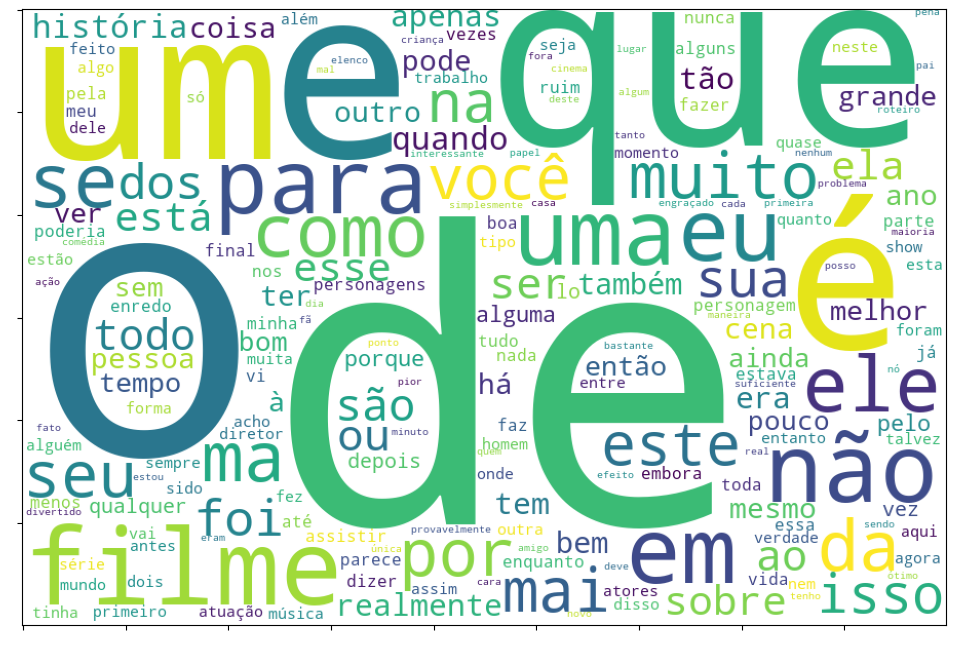

In [49]:
word_cloud = WordCloud(background_color='white',width=900, height=600,
                            collocations=False, prefer_horizontal=1).generate(str(all_sample))

plt.figure(figsize=(16,8))
plt.xticks(color='w', fontsize=0.1)
plt.yticks(color='w', fontsize=0.1)
plt.imshow(word_cloud);

## Cleaning Dataset

In [50]:
import string
string.punctuation

import pyspark.sql.functions as f

In [51]:
data = data.withColumn("text_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./:;<=>?@^_ ´{|}~\\\\]", ' '))
data.limit(5).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [52]:
data = data.withColumn("clean_text", f.trim(data.text_regex))
data.limit(2).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|          text_regex|          clean_text|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr  Co...|Once again Mr  Co...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



## Tokenization

In [53]:
from pyspark.ml.feature import Tokenizer
token = Tokenizer(inputCol="clean_text", outputCol="tokens")
tokenized = token.transform(data)

In [54]:
tokenized.select('clean_text', 'tokens').show()

+--------------------+--------------------+
|          clean_text|              tokens|
+--------------------+--------------------+
|Once again Mr  Co...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a long time...|[being, a, long, ...|
|Tokyo Eyes  tells...|[tokyo, eyes, , t...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all  I w...|[first, of, all, ...|
|So tell me   what...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [55]:
from pyspark.sql.types import IntegerType

count_tokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenized.select('clean_text', 'tokens').withColumn('tokens_freq', count_tokens(f.col('tokens'))).show()

+--------------------+--------------------+-----------+
|          clean_text|              tokens|tokens_freq|
+--------------------+--------------------+-----------+
|Once again Mr  Co...|[once, again, mr,...|        184|
|This is an exampl...|[this, is, an, ex...|        268|
|First of all I ha...|[first, of, all, ...|        233|
|Not even the Beat...|[not, even, the, ...|        337|
|Brass pictures mo...|[brass, pictures,...|        268|
|A funny thing hap...|[a, funny, thing,...|        138|
|This German horro...|[this, german, ho...|        173|
|Being a long time...|[being, a, long, ...|        164|
|Tokyo Eyes  tells...|[tokyo, eyes, , t...|        153|
|Wealthy horse ran...|[wealthy, horse, ...|        185|
|Cage plays a drun...|[cage, plays, a, ...|        118|
|First of all  I w...|[first, of, all, ...|        357|
|So tell me   what...|[so, tell, me, , ...|        269|
|A big disappointm...|[a, big, disappoi...|        122|
|This film is abso...|[this, film, is, ...|     

## NLTK

In [56]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [57]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ronald/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
from nltk.corpus import stopwords
stop_a = stopwords.words("portuguese")

In [59]:
stop_a

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [60]:
from pyspark.ml.feature import StopWordsRemover

stop_b = StopWordsRemover.loadDefaultStopWords("portuguese")
stop_b

['de',
 'a',
 'o',
 'que',
 'e',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera',
 'es

In [61]:
tokenizer = Tokenizer(inputCol="clean_text", outputCol="tokens")
tokenized = tokenizer.transform(data)

In [62]:
remover_a = StopWordsRemover(inputCol='tokens', outputCol='final_text', stopWords=stop_a)
dataset = remover_a.transform(tokenized)
dataset.show(2, truncate=True, vertical=False)

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|          text_regex|          clean_text|              tokens|          final_text|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr  Co...|Once again Mr  Co...|[once, again, mr,...|[once, again, mr,...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[this, is, an, ex...|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [63]:
remover_b = StopWordsRemover(inputCol='tokens', outputCol='final_text', stopWords=stop_a)
dataset = remover_b.transform(tokenized)
dataset.show(2, truncate=True, vertical=False)

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|          text_regex|          clean_text|              tokens|          final_text|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr  Co...|Once again Mr  Co...|[once, again, mr,...|[once, again, mr,...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[this, is, an, ex...|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [64]:
remover = StopWordsRemover(inputCol='tokens', outputCol='final_text')
feature_data = remover.transform(tokenized)
feature_data.limit(3).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|          text_regex|          clean_text|              tokens|          final_text|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr  Co...|Once again Mr  Co...|[once, again, mr,...|[mr, , costner, d...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+



In [65]:
# counting tokens before and after to use stopwords
feature_data.select('tokens', 'final_text').withColumn('text_freq', count_tokens(f.col('tokens')))\
                                           .withColumn('clean_text_freq', count_tokens(f.col('final_text')))\
                                           .show()

+--------------------+--------------------+---------+---------------+
|              tokens|          final_text|text_freq|clean_text_freq|
+--------------------+--------------------+---------+---------------+
|[once, again, mr,...|[mr, , costner, d...|      184|             89|
|[this, is, an, ex...|[example, majorit...|      268|            165|
|[first, of, all, ...|[first, hate, mor...|      233|            125|
|[not, even, the, ...|[even, beatles, w...|      337|            196|
|[brass, pictures,...|[brass, pictures,...|      268|            170|
|[a, funny, thing,...|[funny, thing, ha...|      138|             75|
|[this, german, ho...|[german, horror, ...|      173|             88|
|[being, a, long, ...|[long, time, fan,...|      164|            101|
|[tokyo, eyes, , t...|[tokyo, eyes, , t...|      153|             98|
|[wealthy, horse, ...|[wealthy, horse, ...|      185|            122|
|[cage, plays, a, ...|[cage, plays, dru...|      118|             66|
|[first, of, all, ..

## Count Vectorizer

In [66]:
from pyspark.ml.feature import CountVectorizer

In [67]:
cv = CountVectorizer(inputCol="final_text", outputCol="CountVec")
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('final_text','CountVec').limit(5).show()#truncate=False

22/09/16 15:45:26 WARN DAGScheduler: Broadcasting large task binary with size 1260.1 KiB
+--------------------+--------------------+
|          final_text|            CountVec|
+--------------------+--------------------+
|[mr, , costner, d...|(114971,[0,1,6,8,...|
|[example, majorit...|(114971,[0,2,3,8,...|
|[first, hate, mor...|(114971,[0,1,3,4,...|
|[even, beatles, w...|(114971,[0,1,2,3,...|
|[brass, pictures,...|(114971,[0,2,5,8,...|
+--------------------+--------------------+



In [68]:
model.vocabulary

['',
 'movie',
 'film',
 'one',
 'like',
 'good',
 'time',
 'even',
 'really',
 'story',
 'see',
 'well',
 'much',
 'bad',
 'great',
 'get',
 'people',
 'also',
 'first',
 'dont',
 'movies',
 'made',
 'make',
 'way',
 'films',
 'characters',
 'think',
 'watch',
 'seen',
 'many',
 'two',
 'acting',
 'plot',
 'character',
 'love',
 'never',
 'life',
 'best',
 'show',
 'little',
 'know',
 'ever',
 'better',
 'end',
 'man',
 'still',
 'say',
 'scene',
 'scenes',
 'something',
 'go',
 'im',
 'back',
 'real',
 'watching',
 'actors',
 'thing',
 'funny',
 'years',
 'didnt',
 'doesnt',
 'though',
 'old',
 '10',
 'work',
 'another',
 'actually',
 'nothing',
 'look',
 'makes',
 'find',
 'going',
 'director',
 'lot',
 'new',
 'every',
 'part',
 'cant',
 'cast',
 'thats',
 'want',
 'pretty',
 'things',
 'quite',
 'horror',
 'us',
 'world',
 'around',
 'got',
 'young',
 'thought',
 'seems',
 'big',
 'take',
 'however',
 'enough',
 'fact',
 'long',
 'ive',
 'give',
 'comedy',
 'series',
 'may',
 'rig

## Hasing TF

In [69]:
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="final_text", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [70]:
HTFfeaturizedData.select("final_text", "hashingTF").limit(5).show()

+--------------------+--------------------+
|          final_text|           hashingTF|
+--------------------+--------------------+
|[mr, , costner, d...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



## TF - IDF

In [71]:
#TF-IDF
from pyspark.ml.feature import IDF
idf = IDF(inputCol="hashingTF", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [72]:
TFIDFfeaturizedData.select('final_text', 'features').limit(2).show(truncate = False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Pipeline

In [73]:
TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [74]:
from pyspark.ml.feature import StringIndexer

stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")
data = stringindexer.fit(data).transform(data)

In [75]:
data.groupBy(['sentiment','label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



In [76]:
from pyspark.ml import Pipeline


tokenizer = Tokenizer(inputCol="clean_text", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="final_text")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")


pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf])

In [77]:
dados_transfor = pipeline.fit(data).transform(data)

In [78]:
dados_transfor.limit(2).show(truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Decision Tree

In [79]:
feature_df = dados_transfor.select(['features', 'label'])
feature_df.limit(5).show(truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [80]:
feature_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [81]:
# trasform and adjust pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol="clean_text", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="final_text")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf, dt])

In [82]:
train, test = data.randomSplit([0.8, 0.2], seed=42)
dt_model = pipeline.fit(train)

22/09/16 15:49:34 WARN MemoryStore: Not enough space to cache rdd_330_0 in memory! (computed 45.1 MiB so far)
22/09/16 15:49:34 WARN BlockManager: Persisting block rdd_330_0 to disk instead.


In [83]:
pred = dt_model.transform(test)

In [84]:
pred.limit(10).toPandas()

,id,text_en,text_pt,sentiment,text_regex,clean_text,label,tokens,final_text,HTF,features,rawPrediction,probability,prediction
0,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,First of all I hate those moronic rappers who...,First of all I hate those moronic rappers who...,0.0,"[first, of, all, i, hate, those, moronic, rapp...","[first, hate, moronic, rappers, , couldnt, act...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 2.0461183473509554, 0.0, 0.0, 0.0, 0.0, ...","[114.0, 142.0]","[0.4453125, 0.5546875]",1.0
1,7,This German horror film has to be one of the w...,Este filme de terror alemão tem que ser um dos...,neg,This German horror film has to be one of the w...,This German horror film has to be one of the w...,0.0,"[this, german, horror, film, has, to, be, one,...","[german, horror, film, one, weirdest, seen, aw...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.5720975573697094, 0.0, 0.0, ...","[3142.0, 4581.0]","[0.40683672148128963, 0.5931632785187103]",1.0
2,9,"""Tokyo Eyes"" tells of a 17 year old Japanese g...","""Tokyo Eyes"" fala de uma menina japonesa de 17...",neg,Tokyo Eyes tells of a 17 year old Japanese g...,Tokyo Eyes tells of a 17 year old Japanese gi...,0.0,"[tokyo, eyes, , tells, of, a, 17, year, old, j...","[tokyo, eyes, , tells, 17, year, old, japanese...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.5720975573697094, 0.0, 0.0, ...","[3142.0, 4581.0]","[0.40683672148128963, 0.5931632785187103]",1.0
3,14,A big disappointment for what was touted as an...,Uma grande decepção para o que foi apresentado...,neg,A big disappointment for what was touted as an...,A big disappointment for what was touted as an...,0.0,"[a, big, disappointment, for, what, was, toute...","[big, disappointment, touted, incredible, film...","(0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.1441951147394187, 0.0, 0.0, ...","[10.0, 24.0]","[0.29411764705882354, 0.7058823529411765]",1.0
4,20,New York family is the last in their neighborh...,A família de Nova York é a última em seu bairr...,neg,New York family is the last in their neighborh...,New York family is the last in their neighborh...,0.0,"[new, york, family, is, the, last, in, their, ...","[new, york, family, last, neighborhood, get, t...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[660.0, 287.0]","[0.6969376979936642, 0.30306230200633577]",0.0
5,24,"Sure, most of the slasher films of the 1980s w...","Claro, a maioria dos filmes de terror da décad...",neg,Sure most of the slasher films of the 1980s w...,Sure most of the slasher films of the 1980s w...,0.0,"[sure, , most, of, the, slasher, films, of, th...","[sure, , slasher, films, 1980s, worth, thecell...","(0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 2.8604877868485468, 0.0, 0.0, ...","[1624.0, 467.0]","[0.7766618842659014, 0.2233381157340985]",0.0
6,30,"Supercraptastic slasher fare, which feels over...","Receita de slash supercraptástico, que parece ...",neg,Supercraptastic slasher fare which feels over...,Supercraptastic slasher fare which feels over...,0.0,"[supercraptastic, slasher, fare, , which, feel...","[supercraptastic, slasher, fare, , feels, over...","(1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, ...","(1.5537610872905603, 2.0461183473509554, 0.0, ...","[0.0, 9.0]","[0.0, 1.0]",1.0
7,36,All the criticisms of this movie are quite val...,Todas as críticas deste filme são bastante vál...,neg,All the criticisms of this movie are quite val...,All the criticisms of this movie are quite val...,0.0,"[all, the, criticisms, of, this, movie, are, q...","[criticisms, movie, quite, valid, , pretty, bo...","(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 2.0461183473509554, 0.0, 0.0, 2.82008887...","[3142.0, 4581.0]","[0.40683672148128963, 0.5931632785187103]",1.0
8,46,The filmmaker stayed tr

In [85]:
pred.select(['label', 'prediction']).limit(25).toPandas()

,label,prediction
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,0.0
5,0.0,0.0
6,0.0,1.0
7,0.0,1.0
8,0.0,0.0
9,0.0,0.0


In [98]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',
                                                    metricName='accuracy')
accuracy_tree = evaluator.evaluate(pred)                                                

In [87]:
print(f"Accuracy: {round(accuracy_tree,4)*100}%")

Accuracy: 68.02%


In [95]:
new_base = spark.createDataFrame([
    (0, "I love my first met with my with, it was amazing"),
    (1, "I hate you!"),
    (2, "how many people do knew?"),
    (3, "First of all I hate those moronic rappers")
], ["id", "clean_text"])

In [96]:
new_class = dt_model.transform(new_base)
new_class.limit(4).toPandas()

,id,clean_text,tokens,final_text,HTF,features,rawPrediction,probability,prediction
0,0,"I love my first met with my with, it was amazing","[i, love, my, first, met, with, my, with,, it,...","[love, first, met, with,, amazing]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3142.0, 4581.0]","[0.40683672148128963, 0.5931632785187103]",1.0
1,1,I hate you!,"[i, hate, you!]","[hate, you!]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3142.0, 4581.0]","[0.40683672148128963, 0.5931632785187103]",1.0
2,2,how many people do knew?,"[how, many, people, do, knew?]","[many, people, knew?]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3142.0, 4581.0]","[0.40683672148128963, 0.5931632785187103]",1.0
3,3,First of all I hate those moronic rappers,"[first, of, all, i, hate, those, moronic, rapp...","[first, hate, moronic, rappers]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3142.0, 4581.0]","[0.40683672148128963, 0.5931632785187103]",1.0
